In [1]:
import gym
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import itertools
import sys
from collections import defaultdict
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv
%matplotlib inline
matplotlib.style.use('ggplot')


In [2]:
env = CliffWalkingEnv()


In [3]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [4]:
action = ["up", "right", "down", "left"]

In [5]:
# 4x12 grid = 48 states
print ("Number of states:", env.nS)
# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

Number of states: 48
Number of actions that an agent can take: 4


In [6]:
# Where am I? -> in "x" state
print ("Current state", env.s)
# What are my options? -> 4 action
print ("Transitions from current state:", env.P[env.s])

Current state 36
Transitions from current state: {0: [(1.0, 24, -1, False)], 1: [(1.0, 36, -100, False)], 2: [(1.0, 36, -1, False)], 3: [(1.0, 36, -1, False)]}


In [7]:
# Taking a step by selecting a random action[up=0, right=1, down=2, left=3] from current state
# next state: Where do I end up?
# reward: What rewards did I recieve?
# is_terminal: did I end up in the goal state?
# t_prob: What is probability of ending up in next state taking that action?
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

Action taken: up
Transition probability: {'prob': 1.0}
Next state: 24
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T



In [8]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pi = np.ones(nA, dtype=float) * (epsilon/nA)
        best_action = np.argmax(Q[observation])
        pi[best_action] += (1.0 - epsilon)
        return pi
    
    return policy_fn

In [9]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
    
        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # Approach : 1
        # Takes a lot a lot lot of time to run
        # ep = generate_episode(policy)
        # for i in range(len(ep)-1):
        #     state, action, reward = ep[i]
        #     next_state, next_action, next_reward = ep[i+1]
        
        #     td_target = reward + discount_factor * Q[next_state][next_action]
        #     td_error = td_target - Q[state][action]
        #     Q[state][action] += alpha * td_error

        #     stats.episode_rewards[i_episode] += reward
        #     stats.episode_lengths[i_episode] = t

        # Approach : 2
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
            
            # Pick the next action
            next_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_probs)), p=next_probs)
            
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = next_action

    return Q, stats

In [10]:

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [11]:
%%time
Q, stats = sarsa(env, 200)

Episode 200/200.Wall time: 297 ms


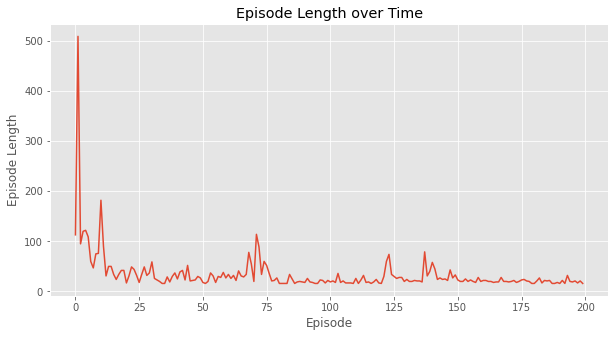

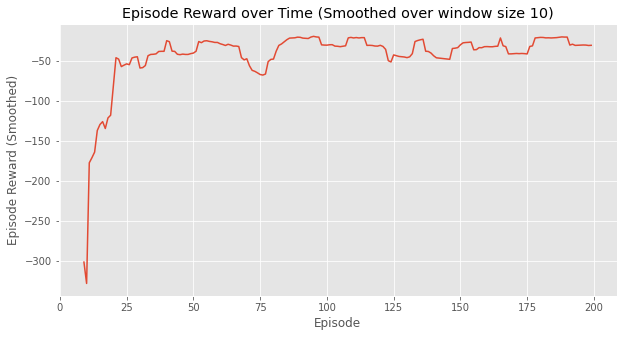

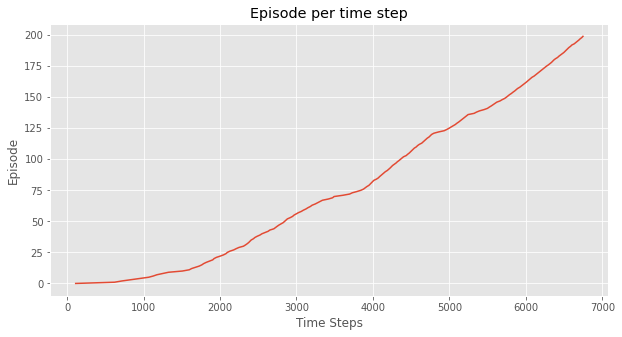

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [12]:
plot_episode_stats(stats)

In [13]:
# get greedy policy from Q
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])
print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  0  0  0  3  1  0  0  1  1  0  2]
 [ 0  0  1  0  3  1  0  1  1  0  0  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right'
  'right' 'right' 'down']
 ['right' 'up' 'up' 'up' 'left' 'right' 'up' 'up' 'right' 'right' 'up'
  'down']
 ['up' 'up' 'right' 'up' 'left' 'right' 'up' 'right' 'right' 'up' 'up'
  'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-19.34835901 -15.83755317 -14.54386621 -13.47815041 -12.00351933
  -10.63001235  -9.45161218  -7.8241581   -7.29127572  -7.11557654
   -5.30295552  -3.33336051]
 [-18.98887759 -17.50229312 -16.67930246 -16.21752196 -17.10287486
  -12.98345779 -11.55623663  -9.81688767  -7.84492345  -6.53426852
   -6.1634607   -2.06058969]
 [-20.03834759 -18.49162194 -18.59058898 -17.60137263 -17.18180577
  -13.26502041 -12.25489975  -9.960320

In [14]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()


        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        

        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
                       
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = best_next_action

    return Q, stats

In [15]:
%%time
Q, stats = q_learning(env, 500)

Episode 500/500.Wall time: 148 ms


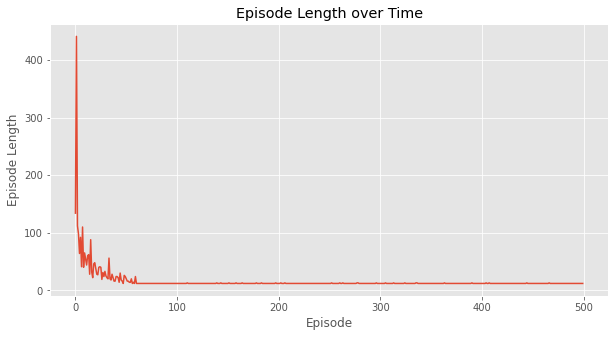

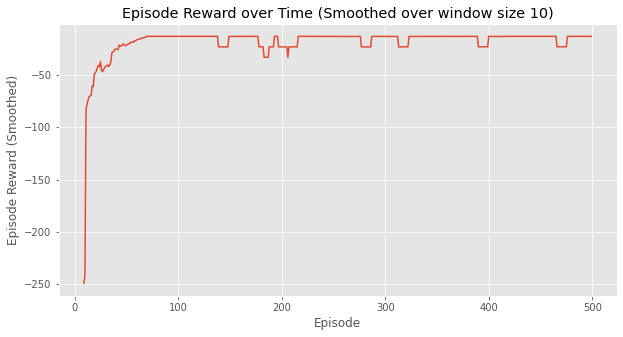

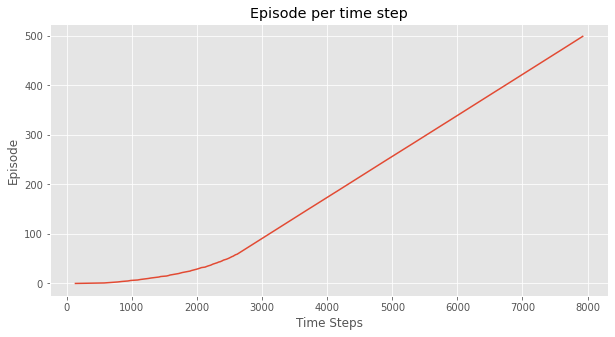

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [16]:
plot_episode_stats(stats)

In [17]:
# get greedy policy from Q
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])
print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 1  1  1  2  2  1  1  1  2  1  1  2]
 [ 1  1  0  1  3  1  1  2  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['right' 'right' 'right' 'down' 'down' 'right' 'right' 'right' 'down'
  'right' 'right' 'down']
 ['right' 'right' 'up' 'right' 'left' 'right' 'right' 'down' 'right'
  'right' 'down' 'down']
 ['right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right'
  'right' 'right' 'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-11.1339619  -10.628736    -9.95425626  -9.1882717   -8.46938868
   -7.64126222  -6.95511374  -6.18331443  -5.3061077   -4.5489931
   -3.70860939  -2.94821961]
 [-11.36207581 -10.78245174  -9.89770311  -9.14756348  -8.31137949
   -7.51620908  -6.63177683  -5.76088237  -4.84638692  -3.942866
   -2.98186038  -1.99986803]
 [-12.         -11.         -10.          -9.          -8.
   -7.          -6. 

In [18]:
def b_pessimistic_q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, beta=0.1):
    """
    B-pessimistic Q-Learning algorithm: the B-pessimistic action-values represent the
    expected value of performing an action followed by actions which are highest valued
    with probability 1−B, or lowest valued with probability B.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()


        # Reset the environment and pick the first action
        state = env.reset()
        probs = policy(state)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        # Approach : 2
        # One step in the environment
        for t in itertools.count():
            # Take a step
            next_state, reward, is_terminal, _ = env.step(action)
                       
            best_next_action = np.argmax(Q[next_state])
            worst_next_action = np.argmin(Q[next_state])
            td_target = reward + discount_factor * ((1-beta) * Q[next_state][best_next_action] + beta * Q[next_state][worst_next_action])
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            if is_terminal:
                break
            
            state = next_state
            action = best_next_action

    return Q, stats

In [19]:
%%time
Q, stats = b_pessimistic_q_learning(env, 500)

Episode 500/500.Wall time: 169 ms


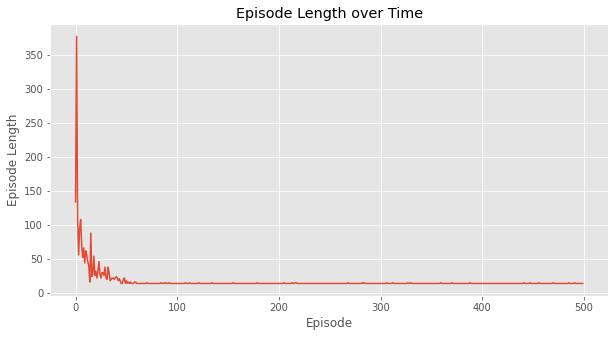

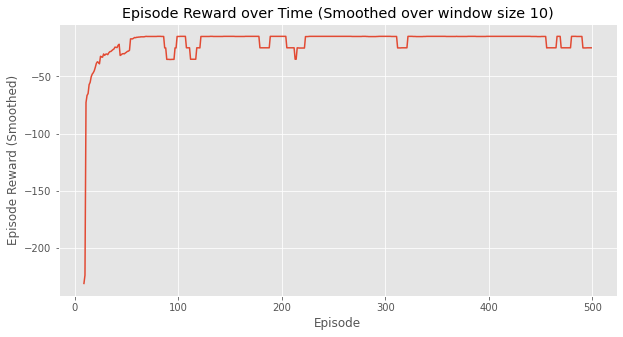

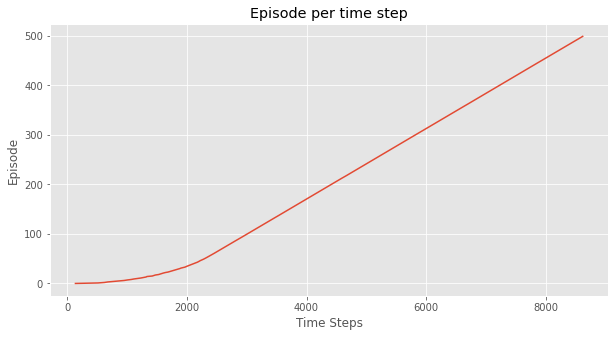

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [20]:
plot_episode_stats(stats)

In [22]:
# get greedy policy from Q
policy = np.array([np.argmax(Q[key]) if key in Q else -1 for key in np.arange(48)])
# get value function from Q using greedy policy
v = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])
print("Reshaped Grid Policy:")
actions = np.stack([action for _ in range(len(policy))], axis=0)
print (np.reshape(policy, (4, 12)))
print ("")

print ("Optimal Policy:")
print(np.take(actions, np.reshape(policy, (4, 12))))
print("")

print("Optimal Value Function:")
print(np.reshape(v, (4, 12)))
print("")

Reshaped Grid Policy:
[[ 0  3  2  1  1  1  1  2  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0  3  0  1  3  3  0  0  3  0  0  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]

Optimal Policy:
[['up' 'left' 'down' 'right' 'right' 'right' 'right' 'down' 'right'
  'right' 'down' 'down']
 ['right' 'right' 'right' 'right' 'right' 'right' 'right' 'right' 'right'
  'right' 'right' 'down']
 ['up' 'left' 'up' 'right' 'left' 'left' 'up' 'up' 'left' 'up' 'up'
  'down']
 ['up' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left' 'left'
  'left' 'up']]

Optimal Value Function:
[[-13.61144902 -12.96287735 -12.14361269 -11.27832729 -10.25794323
   -9.28812708  -8.31782208  -7.34936904  -6.36605199  -5.37125687
   -4.3431811   -3.32747225]
 [-14.36370207 -13.34845328 -12.29041845 -11.23564205 -10.14628892
   -8.9668514   -7.7291742   -6.61783492  -5.51290505  -4.36024928
   -3.33083626  -2.27193974]
 [-15.46703953 -12.48395438 -10.45863416  -9.50846941  -7.27013518
   -7.34640101  -6.71567296  

# Deep RL

In [23]:
import gym
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv
import tensorflow as tf
import numpy as np
from tensorflow import keras

from collections import deque
import time
import random
import itertools

env = CliffWalkingEnv()
# An episode a full game
train_episodes = 1000
test_episodes = 100

def agent(state_shape, action_shape):
    """ The agent maps X-states to Y-actions
    e.g. The neural network output is [.1, .7, .1, .3]
    The highest value 0.7 is the Q-Value.
    The index of the highest action (0.7) is action #1.
    """
    learning_rate = 0.001
    init = tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    model.add(keras.layers.Dense(32, input_shape=state_shape, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(32, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
    #loss=tf.keras.losses.Huber()
    return model

def get_qs(model, state, step):
    return model.predict(state.reshape([1, state.shape[0]]))[0]

def to_one_hot(states):
    shape = (len(states), env.nS)
    one_hot = np.zeros(shape)
    rows = np.arange(states.size)
    one_hot[rows, states] = 1
    return one_hot

def to_xy_coords(states):
    xy_states = []
    for state in states:
        if state == 0: # first row
            xy_states.append(np.array([0,0]))
        elif state == 1:
            xy_states.append(np.array([0,1]))
        elif state == 2:
            xy_states.append(np.array([0,2]))
        elif state == 3:
            xy_states.append(np.array([0,3]))
        elif state == 4:
            xy_states.append(np.array([0,4]))
        elif state == 5:
            xy_states.append(np.array([0,5]))
        elif state == 6:
            xy_states.append(np.array([0,6]))
        elif state == 7:
            xy_states.append(np.array([0,7]))
        elif state == 8:
            xy_states.append(np.array([0,8]))
        elif state == 9:
            xy_states.append(np.array([0,9]))
        elif state == 10:
            xy_states.append(np.array([0,10]))
        elif state == 11:
            xy_states.append(np.array([0,11]))
        elif state == 12: # second row
            xy_states.append(np.array([1,0]))
        elif state == 13:
            xy_states.append(np.array([1,1]))
        elif state == 14:
            xy_states.append(np.array([1,2]))
        elif state == 15:
            xy_states.append(np.array([1,3]))
        elif state == 16:
            xy_states.append(np.array([1,4]))
        elif state == 17:
            xy_states.append(np.array([1,5]))
        elif state == 18:
            xy_states.append(np.array([1,6]))
        elif state == 19:
            xy_states.append(np.array([1,7]))
        elif state == 20:
            xy_states.append(np.array([1,8]))
        elif state == 21:
            xy_states.append(np.array([1,9]))
        elif state == 22:
            xy_states.append(np.array([1,10]))
        elif state == 23:
            xy_states.append(np.array([1,11]))
        elif state == 24: # third row
            xy_states.append(np.array([2,0]))
        elif state == 25:
            xy_states.append(np.array([2,1]))
        elif state == 26:
            xy_states.append(np.array([2,2]))
        elif state == 27:
            xy_states.append(np.array([2,3]))
        elif state == 28:
            xy_states.append(np.array([2,4]))
        elif state == 29:
            xy_states.append(np.array([2,5]))
        elif state == 30:
            xy_states.append(np.array([2,6]))
        elif state == 31:
            xy_states.append(np.array([2,7]))
        elif state == 32:
            xy_states.append(np.array([2,8]))
        elif state == 33:
            xy_states.append(np.array([2,9]))
        elif state == 34:
            xy_states.append(np.array([2,10]))
        elif state == 35:
            xy_states.append(np.array([2,11]))
        elif state == 36: # fourth row
            xy_states.append(np.array([3,0]))
        elif state == 37:
            xy_states.append(np.array([3,1]))
        elif state == 38:
            xy_states.append(np.array([3,2]))
        elif state == 39:
            xy_states.append(np.array([3,3]))
        elif state == 40:
            xy_states.append(np.array([3,4]))
        elif state == 41:
            xy_states.append(np.array([3,5]))
        elif state == 42:
            xy_states.append(np.array([3,6]))
        elif state == 43:
            xy_states.append(np.array([3,7]))
        elif state == 44:
            xy_states.append(np.array([3,8]))
        elif state == 45:
            xy_states.append(np.array([3,9]))
        elif state == 46:
            xy_states.append(np.array([3,10]))
        elif state == 47:
            xy_states.append(np.array([3,11]))
        else:
            print("Invalid state.")
            
    return np.array(xy_states)

def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.7 # Learning rate
    discount_factor = 0.618

    MIN_REPLAY_SIZE = 1000
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return

    batch_size = 64 * 2
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_states = to_one_hot(current_states) #####
    #current_states = to_xy_coords(current_states)
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    new_current_states = to_one_hot(new_current_states) #####
    #new_current_states = to_xy_coords(new_current_states)
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        X.append(observation)
        Y.append(current_qs)
    X = to_one_hot(np.asarray(X)) #####
    #X = to_xy_coords(np.asarray(X))
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
max_epsilon = 1 # You can't explore more than 100% of the time
min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
decay = 0.01

# 1. Initialize the Target and Main models
# Main Model (updated every 4 steps)
model = agent((env.nS,), env.action_space.n) #####
#model = agent((2,), env.action_space.n)
# Target Model (updated every 100 steps)
target_model = agent((env.nS,), env.action_space.n) #####
#target_model = agent((2,), env.action_space.n)
target_model.set_weights(model.get_weights())

replay_memory = deque(maxlen=50_000)

target_update_counter = 0

# X = states, y = actions
X = []
y = []

steps_to_update_target_model = 0

# Keeps track of useful statistics
stats = EpisodeStats(
    episode_lengths=np.zeros(train_episodes),
    episode_rewards=np.zeros(train_episodes)) 

for episode in range(train_episodes):
    total_training_rewards = 0
    observation = env.reset()
    done = False
    for t in itertools.count():
        steps_to_update_target_model += 1
        #if True:
        #    env.render()

        random_number = np.random.rand()
        # 2. Explore using the Epsilon Greedy Exploration Strategy
        if random_number <= epsilon:
            # Explore
            action = env.action_space.sample()
        else:
            # Exploit best known action
            # model dims are (batch, env.observation_space.n)
            encoded = observation
            #encoded_reshaped = encoded.reshape([1, encoded.shape[0]]) # ERROR
            #predicted = model.predict(encoded_reshaped).flatten()
            predicted = model.predict(to_one_hot(np.asarray([encoded]))) #####
            #predicted = model.predict(to_xy_coords(np.asarray([encoded])))
            action = np.argmax(predicted)
        new_observation, reward, done, info = env.step(action)
        replay_memory.append([observation, action, reward, new_observation, done])
        
        # 3. Update the Main Network using the Bellman Equation
        if steps_to_update_target_model % 4 == 0 or done:
            train(env, replay_memory, model, target_model, done)

        observation = new_observation
        total_training_rewards += reward
        
        if done or t > 1000:
            print('Total training rewards: {} after n steps = {} with final reward = {}'.format(total_training_rewards, episode, reward))
            stats.episode_rewards[episode] = total_training_rewards
            stats.episode_lengths[episode] = t
            total_training_rewards += 1

            if steps_to_update_target_model >= 100:
                print('Copying main network weights to the target network weights')
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
env.close()

Total training rewards: -9516 after n steps = 0 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -5043 after n steps = 1 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -8526 after n steps = 2 with final reward = -100
Copying main network weights to the target network weights
Total training rewards: -8625 after n steps = 3 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -7932 after n steps = 4 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -11595 after n steps = 5 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -10308 after n steps = 6 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -5446 after n steps = 7 with final reward = -1
Copying main ne

Total training rewards: -537 after n steps = 69 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -1288 after n steps = 70 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -1362 after n steps = 71 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -78 after n steps = 72 with final reward = -1
Total training rewards: -1379 after n steps = 73 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -280 after n steps = 74 with final reward = -1
Total training rewards: -268 after n steps = 75 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -478 after n steps = 76 with final reward = -1
Total training rewards: -40 after n steps = 77 with final reward = -1
Copying main network weights to the target network weights
Total 

Total training rewards: -594 after n steps = 148 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -352 after n steps = 149 with final reward = -1
Total training rewards: -76 after n steps = 150 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -1224 after n steps = 151 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -782 after n steps = 152 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -1120 after n steps = 153 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -473 after n steps = 154 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -26 after n steps = 155 with final reward = -1
Total training rewards: -909 after n steps = 156 with final reward = -

Total training rewards: -48 after n steps = 231 with final reward = -1
Total training rewards: -82 after n steps = 232 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -374 after n steps = 233 with final reward = -1
Total training rewards: -155 after n steps = 234 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -278 after n steps = 235 with final reward = -1
Total training rewards: -459 after n steps = 236 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -38 after n steps = 237 with final reward = -1
Total training rewards: -55 after n steps = 238 with final reward = -1
Total training rewards: -36 after n steps = 239 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -28 after n steps = 240 with final reward = -1
Total training rewards: -284 after n steps = 241 w

Total training rewards: -413 after n steps = 315 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -301 after n steps = 316 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -153 after n steps = 317 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -85 after n steps = 318 with final reward = -1
Total training rewards: -102 after n steps = 319 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -144 after n steps = 320 with final reward = -1
Total training rewards: -66 after n steps = 321 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -65 after n steps = 322 with final reward = -1
Total training rewards: -38 after n steps = 323 with final reward = -1
Copying main network weights to the target network weights
To

Total training rewards: -125 after n steps = 397 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -72 after n steps = 398 with final reward = -1
Total training rewards: -105 after n steps = 399 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -56 after n steps = 400 with final reward = -1
Total training rewards: -39 after n steps = 401 with final reward = -1
Total training rewards: -70 after n steps = 402 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -244 after n steps = 403 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -179 after n steps = 404 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -16 after n steps = 405 with final reward = -1
Total training rewards: -306 after n steps = 406 with final re

Total training rewards: -80 after n steps = 479 with final reward = -1
Total training rewards: -272 after n steps = 480 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -25 after n steps = 481 with final reward = -1
Total training rewards: -397 after n steps = 482 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -16 after n steps = 483 with final reward = -1
Total training rewards: -131 after n steps = 484 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -15 after n steps = 485 with final reward = -1
Total training rewards: -48 after n steps = 486 with final reward = -1
Total training rewards: -38 after n steps = 487 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -18 after n steps = 488 with final reward = -1
Total training rewards: -15 after n steps = 489 wit

Total training rewards: -42 after n steps = 564 with final reward = -1
Total training rewards: -23 after n steps = 565 with final reward = -1
Total training rewards: -185 after n steps = 566 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -66 after n steps = 567 with final reward = -1
Total training rewards: -35 after n steps = 568 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -37 after n steps = 569 with final reward = -1
Total training rewards: -241 after n steps = 570 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -76 after n steps = 571 with final reward = -1
Total training rewards: -39 after n steps = 572 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -201 after n steps = 573 with final reward = -1
Copying main network weights to the target network 

Total training rewards: -41 after n steps = 645 with final reward = -1
Total training rewards: -18 after n steps = 646 with final reward = -1
Total training rewards: -17 after n steps = 647 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -122 after n steps = 648 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -188 after n steps = 649 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -25 after n steps = 650 with final reward = -1
Total training rewards: -66 after n steps = 651 with final reward = -1
Total training rewards: -68 after n steps = 652 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -13 after n steps = 653 with final reward = -1
Total training rewards: -24 after n steps = 654 with final reward = -1
Total training rewards: -96 after n steps = 655 with

Total training rewards: -19 after n steps = 726 with final reward = -1
Total training rewards: -62 after n steps = 727 with final reward = -1
Total training rewards: -20 after n steps = 728 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -83 after n steps = 729 with final reward = -1
Total training rewards: -24 after n steps = 730 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -162 after n steps = 731 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -31 after n steps = 732 with final reward = -1
Total training rewards: -66 after n steps = 733 with final reward = -1
Total training rewards: -25 after n steps = 734 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -253 after n steps = 735 with final reward = -1
Copying main network weights to the target network w

Total training rewards: -97 after n steps = 811 with final reward = -1
Total training rewards: -81 after n steps = 812 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -98 after n steps = 813 with final reward = -1
Total training rewards: -123 after n steps = 814 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -232 after n steps = 815 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -26 after n steps = 816 with final reward = -1
Total training rewards: -25 after n steps = 817 with final reward = -1
Total training rewards: -62 after n steps = 818 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -21 after n steps = 819 with final reward = -1
Total training rewards: -68 after n steps = 820 with final reward = -1
Total training rewards: -943 after n steps = 821 wit

Total training rewards: -60 after n steps = 889 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -41 after n steps = 890 with final reward = -1
Total training rewards: -79 after n steps = 891 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -98 after n steps = 892 with final reward = -1
Total training rewards: -68 after n steps = 893 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -99 after n steps = 894 with final reward = -1
Total training rewards: -33 after n steps = 895 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -23 after n steps = 896 with final reward = -1
Total training rewards: -161 after n steps = 897 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -60 after n steps = 898 with final reward

Total training rewards: -39 after n steps = 965 with final reward = -1
Total training rewards: -548 after n steps = 966 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -210 after n steps = 967 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -176 after n steps = 968 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -238 after n steps = 969 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -33 after n steps = 970 with final reward = -1
Total training rewards: -124 after n steps = 971 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -139 after n steps = 972 with final reward = -1
Copying main network weights to the target network weights
Total training rewards: -26 after n steps = 973 with final reward = -1
T

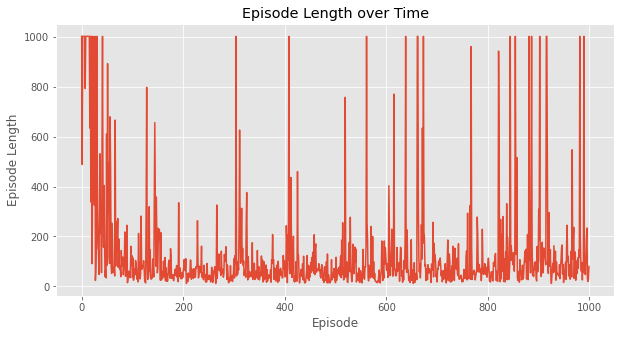

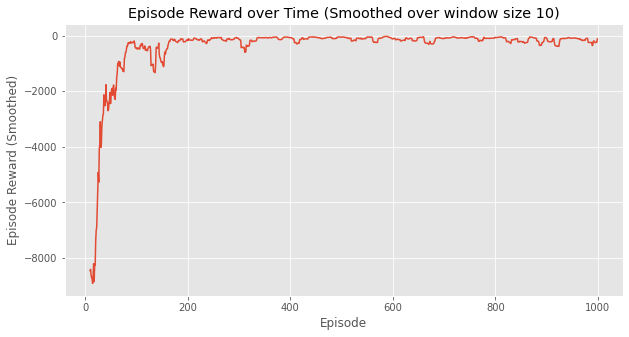

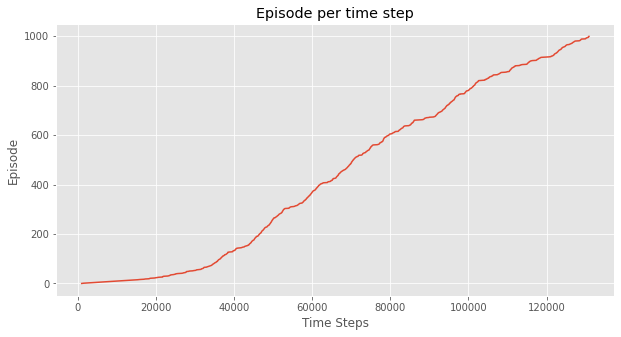

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [24]:
plot_episode_stats(stats)

In [25]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
actions = ["up", "right", "down", "left"]
print(f"actions: [UP, RIGHT, DOWN, LEFT]")
for i in range(env.nS):
    print(f"state {i}: {target_model.predict(to_one_hot(np.asarray([i])))}")

print ("Optimal Policy:")
env.render()
j = 1
for i in range(env.nS):
    max_val = np.argmax(model.predict(to_one_hot(np.asarray([i]))))
    if max_val == 0:
        print(f" ^ ", end="")
    elif max_val == 1:
        print(f" > ", end="")
    elif max_val == 2:
        print(f" v ", end="")
    else:
        print(f" < ", end="")
    if j % 12 == 0:
        j = 1
        print("")
    else:
        j += 1
        

actions: [UP, RIGHT, DOWN, LEFT]
state 0: [[-2.531979  -2.6566746 -2.4546661 -2.5207894]]
state 1: [[-2.535156  -2.6753113 -2.5482855 -2.5106328]]
state 2: [[-2.5110426 -2.498549  -2.597657  -2.5040405]]
state 3: [[-2.516539  -2.588532  -2.366252  -2.5217578]]
state 4: [[-2.450592  -2.4896913 -2.5588844 -2.496833 ]]
state 5: [[-2.493119  -2.5276637 -2.4734616 -2.4918003]]
state 6: [[-2.4593012 -2.4708016 -2.641469  -2.4925418]]
state 7: [[-2.3747406 -2.4465787 -2.478887  -2.4385643]]
state 8: [[-2.2716095 -2.4028804 -2.3103359 -2.3859665]]
state 9: [[-2.2543125 -2.0996182 -2.3229868 -2.3535724]]
state 10: [[-2.2402399 -2.2324674 -2.8932514 -2.3200822]]
state 11: [[-2.1552317 -2.2970326 -2.087981  -2.2642243]]
state 12: [[-2.4812179 -2.5780518 -2.5736403 -2.5104961]]
state 13: [[-2.5001824 -2.5150397 -2.5619535 -2.5179675]]
state 14: [[-2.5340042 -2.4855535 -2.5624273 -2.5229971]]
state 15: [[-2.4904935 -2.6306872 -2.543509  -2.5206242]]
state 16: [[-2.4930966 -2.5536695 -2.415252  -2.5